# Import Modules

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,5)
import scipy.fftpack
from scipy.fftpack import dct
import scipy.io as sio
from scipy import signal
import copy
import scipy

In [2]:
import keras
from keras import layers, models

C:\Users\Alexandre\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Data

In [3]:
labels = np.load('data/whale_trainlabels.npy')
sounds = np.load('data/whale_traindata.npy')

In [8]:

labels.shape

[0 0 0 ... 0 0 0]


(30000,)

In [9]:
sounds.shape

(30000, 4000)

# Create a basic Neural Network with Dense layers on data

In [10]:
train_data = sounds[:-10000]
train_labels = labels[:-10000]
test_data = sounds[-10000:]
test_labels = labels[-10000:]

In [11]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(sounds.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [12]:
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [13]:
history = model.fit(train_data,
                   train_labels,
                   epochs=20,
                   batch_size=1000,
                   validation_data=(test_data, test_labels))

Train on 20000 samples, validate on 10000 samples
Epoch 1/20
20000/20000 [==============================] - 7s 359us/step - loss: 0.4890 - acc: 0.7677 - val_loss: 0.5129 - val_acc: 0.7446
Epoch 2/20
20000/20000 [==============================] - 4s 200us/step - loss: 0.4072 - acc: 0.7763 - val_loss: 0.5112 - val_acc: 0.7446
Epoch 3/20
20000/20000 [==============================] - 4s 212us/step - loss: 0.3552 - acc: 0.7827 - val_loss: 0.5405 - val_acc: 0.7004
Epoch 4/20
20000/20000 [==============================] - 4s 193us/step - loss: 0.3033 - acc: 0.8332 - val_loss: 0.6172 - val_acc: 0.6844
Epoch 5/20
20000/20000 [==============================] - 4s 192us/step - loss: 0.2532 - acc: 0.8753 - val_loss: 0.7086 - val_acc: 0.6664
Epoch 6/20
20000/20000 [==============================] - 4s 205us/step - loss: 0.2113 - acc: 0.9034 - val_loss: 0.8724 - val_acc: 0.6820
Epoch 7/20
20000/20000 [==============================] - 4s 210us/step - loss: 0.1792 - acc: 0.9228 - val_loss: 0.9591 - 

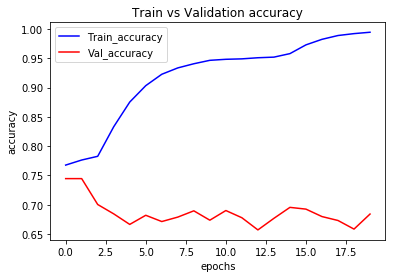

In [14]:
plt.plot(history.history["acc"], "b", label = "Train_accuracy")
plt.plot(history.history["val_acc"], "r", label = "Val_accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Train vs Validation accuracy")
plt.legend()
plt.show()

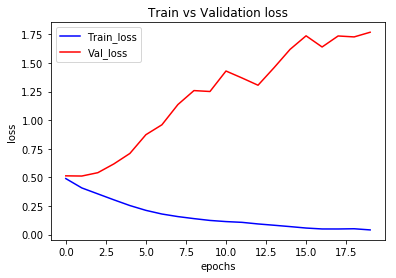

In [16]:
plt.plot(history.history["loss"], "b", label = "Train_loss")
plt.plot(history.history["val_loss"], "r", label = "Val_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Train vs Validation loss")
plt.legend()
plt.show()

* There is obviously a problem of overfitting*

# Time Frequency Analysis 

The following cells create features of shape (number of windows, number of filters) from data (the dataset is sampled at 2kHz).
The other parameters are the following:
* nfilt = number of mel-filters to average spectrograms
* ncep = number of cepstral coefficients to use for MFCCs
* do_dct = True to compute MFCC (otherwise mel-filterbanks are the output)
* lowerf = lowest frequency spanned by the filters (and that will be taken into account by the features)
* higherf = highest frequency spanned by the filters
* alpha = parameter use for the pre-emphasis
* frate = number of frames per second (1/frate is the stride of the windows in seconds)
* wlen = length of windows in seconds
* nfft = number of frequency bins used to compute the spectrogram
* compression = the final compression performed on the mel-filterbanks (before DCT if you put do_dct=True)
* do_deltas = compute the first derivatives of MFCC
* do_deltasdeltas = compute the second derivatives of MFCC

## Extract Speech Features  - Step by step -

### The signal

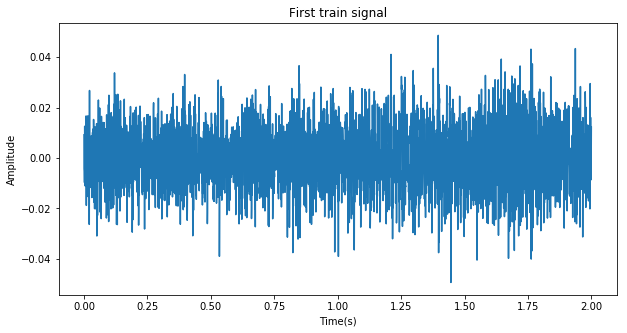

In [69]:
x = np.arange(0, len(sounds[0]))/2000
signal = sounds[0]
plt.plot(x, signal)
plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
plt.title("First train signal")
plt.show()

## Pre-emphasis

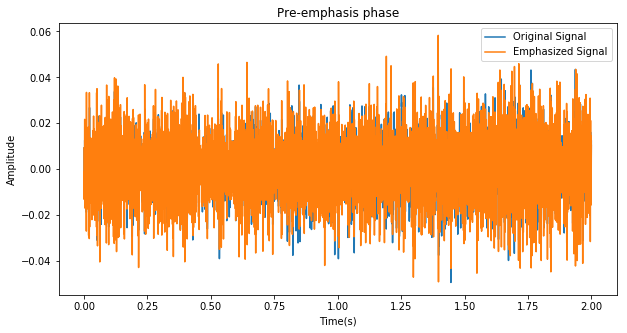

In [70]:
# Parameters
pre_emphasis = .96 # the filter coefficient used to amplify high frequencies
emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
plt.plot(x, signal, label = "Original Signal")
plt.plot(x, emphasized_signal, label = "Emphasized Signal")
plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
plt.title("Pre-emphasis phase")
plt.legend()
plt.show()

## Framing

In [71]:
# Parameters
sample_rate = 2000 # 2 kHz
frame_size = 0.025 # 25 ms
frame_stride = 0.01 # 10ms

In [72]:
# Getting the frames
###On fait différentes fênetres
frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame    


pad_signal_length = num_frames * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal    


indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(np.int32, copy=False)]     

In [73]:
frames.shape

(198, 50)

## Windowing

$$ \forall n \in \{ 0, \dots, N-1 \} \quad w_n = .54 - .46 \cos(\frac{2 \pi n}{N - 1}) \quad \text{where N is the window length}$$


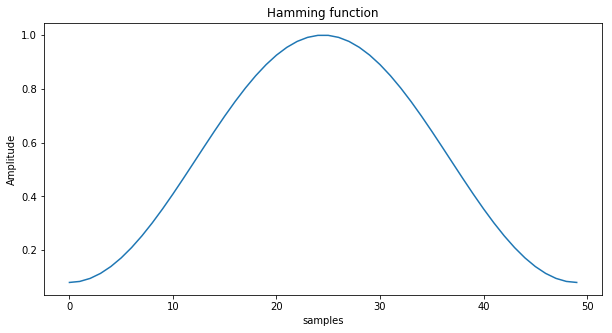

In [75]:
frames *= np.hamming(frame_length)
plt.plot(np.hamming(frame_length))
plt.xlabel("samples")
plt.ylabel("Amplitude")
plt.title("Hamming function")
plt.show()

## Fourier Transform and Power Spectrum

In [76]:
# Parameters
NFFT = 1024 
mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum


# Filters

In [77]:
# Parameters
nfilt = 32

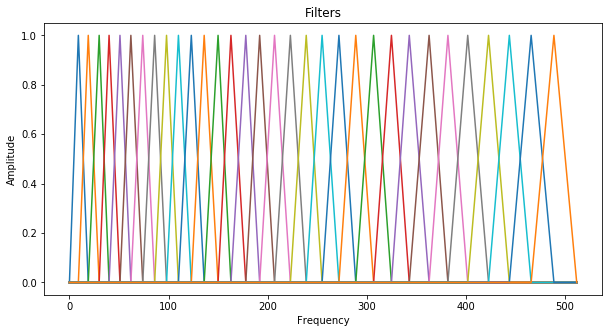

In [78]:
low_freq_mel = 0
high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = np.floor((NFFT + 1) * hz_points / sample_rate)

fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * np.log10(filter_banks)  # dB
for i in range(len(fbank)):
    plt.plot(fbank[i])
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.title("Filters")
plt.show()

# Filterbanks

In [79]:
filter_banks.shape

(198, 32)

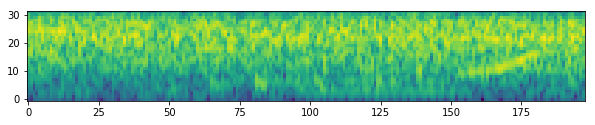

In [81]:
plt.imshow(filter_banks.transpose())
plt.gca().invert_yaxis()

# MFCC

In [82]:
num_ceps = 12
cep_lifter = 22

In [83]:
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13

(nframes, ncoeff) = mfcc.shape
n = np.arange(ncoeff)
lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
mfcc *= lift 

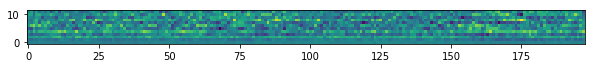

In [84]:
plt.imshow(mfcc.transpose())
plt.gca().invert_yaxis()

## Recap

In [85]:
def filterbanks(signal, sample_rate = 16000, pre_emphasis = 0.97, frame_size = 0.025, frame_stride = 0.01, NFFT = 256, nfilt = 40, norm = True):

    
    emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
    signal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame    


    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal    


    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]        


    frames *= np.hamming(frame_length)

    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum


    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * np.log10(filter_banks)  # dB
    if norm:
        filter_banks -= (np.mean(filter_banks, axis = 0) + 1e-8)   
    return filter_banks

In [129]:
def mfcc(signal, sample_rate= 16000, pre_emphasis = 0.97, frame_size = 0.025, frame_stride = 0.01, NFFT = 256, nfilt = 40, num_ceps = 12, cep_lifter = 22, norm = True):
    
    filter_banks = filterbanks(signal, sample_rate = sample_rate, pre_emphasis = pre_emphasis, frame_size = frame_size, frame_stride = frame_stride, NFFT = NFFT, nfilt = nfilt, norm = False)

    mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13

    (nframes, ncoeff) = mfcc.shape
    n = np.arange(ncoeff)
    lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
    mfcc *= lift 
    if norm:
        mfcc -= (np.mean(mfcc, axis = 0) + 1e-8)   
    return mfcc  

# Compute filterbanks and MFCCs  from sounds

In [57]:
feature_function = filterbanks # try also mfcc 
features = []
for sound in sounds:
    features.append(feature_function(sound))
features = np.asarray(features)

In [87]:
features.shape

(30000, 23, 40)

# CNN

In [59]:
 ##La c'est de la convolution (on reconnait le 1 dans la 1ère ligne) nombre de channel

# Reshape data : (samples, height, width, channel)
data = features.reshape((features.shape[0], features.shape[1], features.shape[2], 1))

train_data = data[:-10000]
train_labels = labels[:-10000]
test_data = data[-10000:]
test_labels = labels[-10000:]

In [62]:
model = keras.Sequential()
model.add(layers.Conv2D(32, (3,3), activation = "relu", input_shape = (data.shape[1], data.shape[2], 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3), activation = "relu"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation = "sigmoid"))


model.compile(optimizer = "RMSprop",
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

In [63]:
history = model.fit(train_data, train_labels, epochs=20, batch_size=200, validation_data=(test_data, test_labels))


Train on 20000 samples, validate on 10000 samples
Epoch 1/20
20000/20000 [==============================] - 24s 1ms/step - loss: 0.4855 - acc: 0.8157 - val_loss: 0.2581 - val_acc: 0.8914
Epoch 2/20
20000/20000 [==============================] - 23s 1ms/step - loss: 0.4820 - acc: 0.8356 - val_loss: 0.5807 - val_acc: 0.8288
Epoch 3/20
20000/20000 [==============================] - 23s 1ms/step - loss: 0.8687 - acc: 0.8273 - val_loss: 0.4770 - val_acc: 0.8834
Epoch 4/20
20000/20000 [==============================] - 24s 1ms/step - loss: 1.1788 - acc: 0.8298 - val_loss: 0.7153 - val_acc: 0.8469
Epoch 5/20
20000/20000 [==============================] - 23s 1ms/step - loss: 1.4052 - acc: 0.8385 - val_loss: 0.3717 - val_acc: 0.9351
Epoch 6/20
20000/20000 [==============================] - 25s 1ms/step - loss: 1.3262 - acc: 0.8435 - val_loss: 0.4376 - val_acc: 0.9273
Epoch 7/20
20000/20000 [==============================] - 24s 1ms/step - loss: 1.1924 - acc: 0.8452 - val_loss: 0.3269 - val_acc

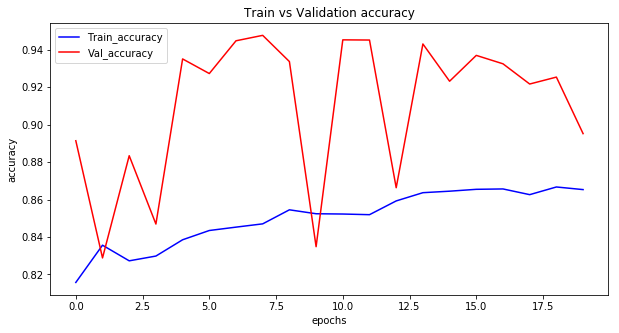

In [64]:
plt.plot(history.history["acc"], "b", label = "Train_accuracy")
plt.plot(history.history["val_acc"], "r", label = "Val_accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Train vs Validation accuracy")
plt.legend()
plt.show()

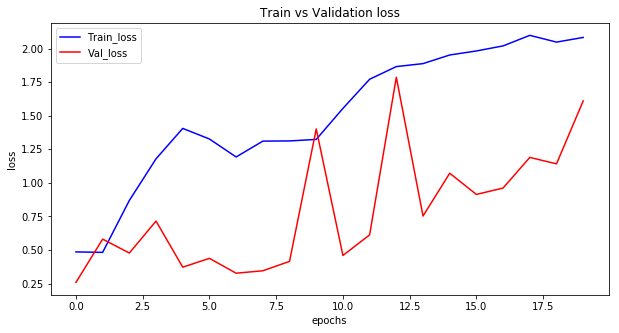

In [66]:
plt.plot(history.history["loss"], "b", label = "Train_loss")
plt.plot(history.history["val_loss"], "r", label = "Val_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Train vs Validation loss")
plt.legend()
plt.show()